# Figure 3 & 4: PCA Saliency Map

## 1. Imports

In [1]:
from pathlib import Path
import json
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cmocean
color_map = cmocean.cm.ice
import matplotlib.gridspec as gridspec

from applefy.utils.file_handling import load_adi_data

from s4hci.utils.data_handling import read_s4hci_root_dir

## 2. Load the dataset

In [2]:
dataset_name = "HD22049_351_096_C-0679_A_"
root_dir = Path(read_s4hci_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [4]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [5]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [6]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

## 3. Bild PCA basis

In [7]:
# 1.) Convert images to torch tensor
im_shape = science_data.shape
images_torch = torch.from_numpy(science_data)

# 2.) remove the mean as needed for PCA
images_torch = images_torch - images_torch.mean(dim=0)

# 3.) reshape images to fit for PCA
images_torch = images_torch.view(im_shape[0], im_shape[1] * im_shape[2])

# 4.) compute PCA basis
_, _, V = torch.svd_lowrank(images_torch, niter=1, q=1000)

In [8]:
pca_number = 300

In [9]:
# 5.) 
input_gradients = torch.matmul(V[:, :pca_number], V[:, :pca_number].T)
input_gradients = np.abs(input_gradients.detach().numpy())
input_gradients = input_gradients.reshape(-1, 91, 91)

## 4. Get an example image and projection

In [10]:
from matplotlib.colors import LogNorm, SymLogNorm

In [11]:
pca_rep = torch.matmul(images_torch, V[:, :pca_number])
noise_estimate = torch.matmul(pca_rep, V[:, :pca_number].T)

idx = 300
example_image = images_torch[idx].reshape(91, 91).numpy()
noise_estiamte = noise_estimate[idx].reshape(91, 91).numpy()

In [12]:
example_image = np.log(example_image - np.min(example_image)*1.1)
noise_estiamte = np.log(noise_estiamte - np.min(noise_estiamte)*1.1)

## 5. Create the First Plot

In [13]:
colors = ["dimgray", "aqua", "darkorange", "crimson"]

In [14]:
def plot_saliency_map(
    axis_in,
    input_gradients,
    position):
    
    idx = position[0] * 91 + position[1]
    axis_in.imshow(input_gradients[idx])
    axis_in.axis("off")
    
    axis_in.scatter(45, 45, color="red", marker="*", s=50)

In [15]:
def add_marker(axis_in, position, color):
    len_markers = 2
    axis_in.vlines(position[1], ymin=-0.5, ymax=-0.5 + len_markers, lw=2, color=color)
    axis_in.vlines(position[1], ymin=90.5 - len_markers, ymax=90.5, lw=2, color=color)
    axis_in.hlines(position[0], xmin=-0.5, xmax=-0.5 + len_markers, lw=2, color=color)
    axis_in.hlines(position[0], xmin=90.5 - len_markers, xmax=90.5, lw=2, color=color)

In [16]:
def add_number_tag(axis_in, position, number, size=12):
    axis_in.text(
        position[1], position[0],
        str(number),
        fontsize=size,
        bbox={"fc":"white",
              "ec":"grey",
              "boxstyle":"circle",
              "alpha":0.5})

In [17]:
position1 = (55, 37)
position2 = (70, 30)
idx1 = position1[0] * 91 + position1[1]
idx2 = position2[0] * 91 + position2[1]

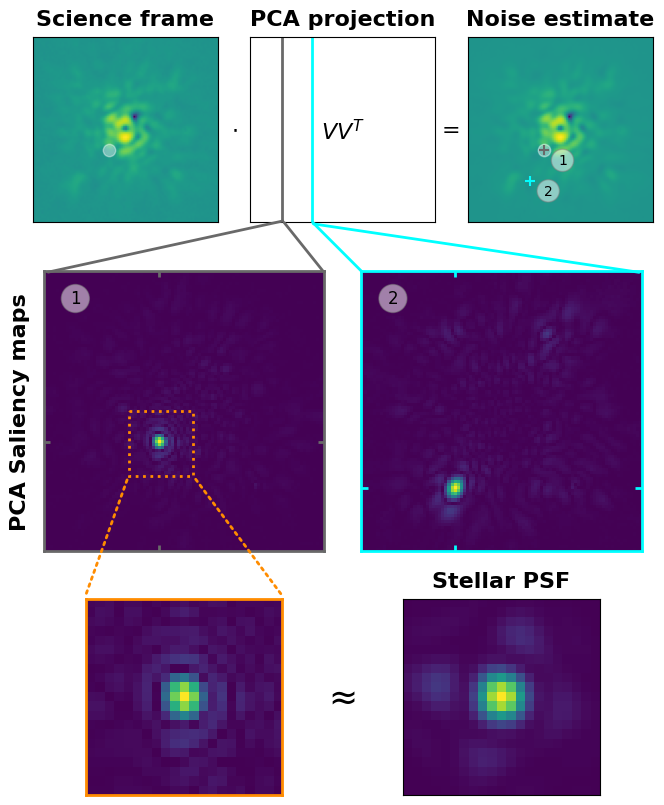

In [50]:
# --------------------------------------------------------------------
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(8, 10))
gs0 = fig.add_gridspec(2, 1, height_ratios=[0.4, 1])
gs0.update(hspace=0.1, wspace=0.0)

# Frame illustrations
gs01 = gridspec.GridSpecFromSubplotSpec(
    1, 5, 
    subplot_spec=gs0[0],
    width_ratios=[1, 0.05, 1, 0.05, 1],
    wspace=0.1, hspace=0.07)

ax_science = fig.add_subplot(gs01[0])
ax_mult = fig.add_subplot(gs01[1])
ax_projection = fig.add_subplot(gs01[2])
ax_equal = fig.add_subplot(gs01[3])
ax_noise_estimate = fig.add_subplot(gs01[4])

# Residual Plots
gs01 = gridspec.GridSpecFromSubplotSpec(
    2, 2, 
    subplot_spec=gs0[1],
    wspace=0.05, hspace=0.2,
    height_ratios = [1, 0.7])

ax_example_1 = fig.add_subplot(gs01[0, 0])
ax_example_2 = fig.add_subplot(gs01[0, 1])
ax_zoom_in = fig.add_subplot(gs01[1, 0])
ax_psf = fig.add_subplot(gs01[1, 1])

# --------------------------------------------------------------------
# 2.) Plot the PCA illustration
ax_science.imshow(example_image)
ax_science.set_xticks([])
ax_science.set_yticks([])
ax_science.set_title(
    "Science frame",
    fontsize=16,
    fontweight="bold", y=1.02)

ax_mult.text(0.5, 0.5, '$\cdot$', color='black', 
             fontsize=16, va='center', ha='center') 
ax_mult.axis("off")

ax_projection.imshow(np.ones_like(noise_estiamte), 
                     vmin=0, vmax=1, cmap='gray')
ax_projection.set_xticks([])
ax_projection.set_yticks([])
ax_projection.text(
    45, 45, '$VV^T$', color='black', 
    fontsize=16, va='center', ha='center') 
ax_projection.set_title(
    "PCA projection",
    fontsize=16, 
    fontweight="bold", y=1.02)
ax_projection.vlines([15], ymin=-1, ymax=92, lw=2, color=colors[0])
ax_projection.vlines([30], ymin=-1, ymax=92, lw=2, color=colors[1])
ax_projection.set_ylim(0, 91)

ax_equal.text(0.5, 0.5, '=', color='black',
              fontsize=16, va='center', ha='center') 
ax_equal.axis("off")

ax_noise_estimate.imshow(noise_estiamte)
ax_noise_estimate.set_xticks([])
ax_noise_estimate.set_yticks([])
ax_noise_estimate.set_title(
    "Noise estimate",
    fontsize=16, 
    fontweight="bold", y=1.02)

# Mark all positions
ax_science.scatter(
    [position1[1]],[position1[0]],
    marker = "o", edgecolors=None,
    color="white", alpha=0.4,
    s=80)
ax_noise_estimate.scatter(
    [position1[1]],[position1[0]],
    marker = "o", edgecolors=None,
    color="white", alpha=0.4,
    s=80)

ax_noise_estimate.scatter(
    [position1[1]],[position1[0]],
    marker = "+",
    color=colors[0],
    s=50)

ax_noise_estimate.scatter(
    [position2[1]],[position2[0]],
    marker = "+",
    color=colors[1],
    s=50)

# --------------------------------------------------------------------
# 3.) Plot the Saliency Maps
ax_example_1.imshow(input_gradients[idx1])
ax_example_1.set_xticks([])
ax_example_1.set_yticks([])
ax_example_2.imshow(input_gradients[idx2])
ax_example_2.set_xticks([])
ax_example_2.set_yticks([])
add_number_tag(ax_example_1, [10, 8], 1)
add_number_tag(ax_example_2, [10, 8], 2)
add_number_tag(ax_noise_estimate, [position1[0]+ 7, position1[1] + 7], 1, 10)
add_number_tag(ax_noise_estimate, [position2[0]+ 7, position2[1] + 7], 2, 10)

plt.setp(ax_example_2.spines.values(), 
         color=colors[1], 
         linewidth=2, 
         linestyle="-")

plt.setp(ax_example_1.spines.values(), 
         color=colors[0], 
         linewidth=2, 
         linestyle="-")

add_marker(ax_example_1, position1, colors[0])
add_marker(ax_example_2, position2, colors[1])

ax_example_1.set_ylabel(
    "PCA Saliency maps", 
    fontsize=16, fontweight="bold", labelpad=10)

# Zoomed in Version ---------------------
ax_example_1.add_patch(Rectangle(
    [position1[1]-10,
     position1[0]-10], 
    21, 21, 
    fill=False, 
    edgecolor=colors[2], 
    lw=2, ls="dotted"))

arrowKwargs = {
        'arrowstyle' : '-',
        'linestyle' : 'dotted',
        'color': colors[2],
        'linewidth':2}

ax_example_1.annotate(
    '', 
    xy=[90.6, 0], 
    xytext=[77, -17], 
    arrowprops={
        'arrowstyle' : '-',
        'linestyle' : '-',
        'color': colors[0],
        'linewidth':2})

ax_example_1.annotate(
    '', 
    xy=[0, 0], 
    xytext=[78, -17], 
    arrowprops={
        'arrowstyle' : '-',
        'linestyle' : '-',
        'color': colors[0],
        'linewidth':2})

ax_example_2.annotate(
    '', 
    xy=[90.6, 0], 
    xytext=[-17, -16], 
    arrowprops={
        'arrowstyle' : '-',
        'linestyle' : '-',
        'color': colors[1],
        'linewidth':2})

ax_example_2.annotate(
    '', 
    xy=[0, 0], 
    xytext=[-17, -17], 
    arrowprops={
        'arrowstyle' : '-',
        'linestyle' : '-',
        'color': colors[1],
        'linewidth':2})

ax_example_1.annotate(
    '', 
    xy=[position1[1]-10,
        position1[0]+11], 
    xytext=[13, 105], 
    arrowprops=arrowKwargs)

ax_example_1.annotate(
    '', 
    xy=[position1[1]+11,
        position1[0]+11], 
    xytext=[77, 105], 
    arrowprops=arrowKwargs)

# Zoom plot
ax_zoom_in.imshow(input_gradients[idx1][
    position1[0]-10:position1[0]+11,
    position1[1]-10:position1[1]+11])
ax_zoom_in.set_xticks([])
ax_zoom_in.set_yticks([])
plt.setp(ax_zoom_in.spines.values(), 
         color=colors[2], 
         linewidth=2, 
         linestyle="-")

# PSF ---------------------
ax_psf.imshow(psf_template)
ax_psf.set_xticks([])
ax_psf.set_yticks([])
ax_psf.set_title("Stellar PSF", fontsize=16, fontweight="bold", y=1.02)
ax_psf.text(-9.2, 11, r'$\approx$', fontsize=25)

# Add Figure Title
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/03_pca_saliency_map.pdf", bbox_inches='tight')

## 6. Plot the trends as a function of separation

In [51]:
from applefy.utils.positions import estimate_noise_positions

In [52]:
def get_matches(pca_number, separations):
    matches = []

    tmp_input_gradients = torch.matmul(V[:, :pca_number], V[:, :pca_number].T)
    tmp_input_gradients = np.abs(tmp_input_gradients.detach().numpy())
    tmp_input_gradients = tmp_input_gradients.reshape(-1, 91, 91)
    
    for tmp_separation in separations:
        positions = np.array(estimate_noise_positions(
            3.6*tmp_separation, 
            (science_data[10].shape[0]/2-1, 
             science_data[10].shape[0]/2-1), 
            3.6/2))[:, :2].astype(int)
        
        indices = positions[:, 0]*91 + positions[:, 1]
        extracted = np.array([tmp_input_gradients[indices][i][
            positions[i, 0]-10:positions[i, 0]+11, 
            positions[i, 1]-10:positions[i, 1]+11] for i in range(len(positions))])
        
        tmp_match = np.mean((extracted*psf_template).sum(axis=(1, 2)))
        matches.append(tmp_match)
        
    return matches

In [53]:
pca_matches = []
pca_number = np.arange(1, 500, 10)

for tmp_pca in tqdm(pca_number):
    tmp_matches = get_matches(tmp_pca, [1.5, 4, 8])
    pca_matches.append(tmp_matches)

pca_matches = np.array(pca_matches)
pca_matches /= np.max(pca_matches)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


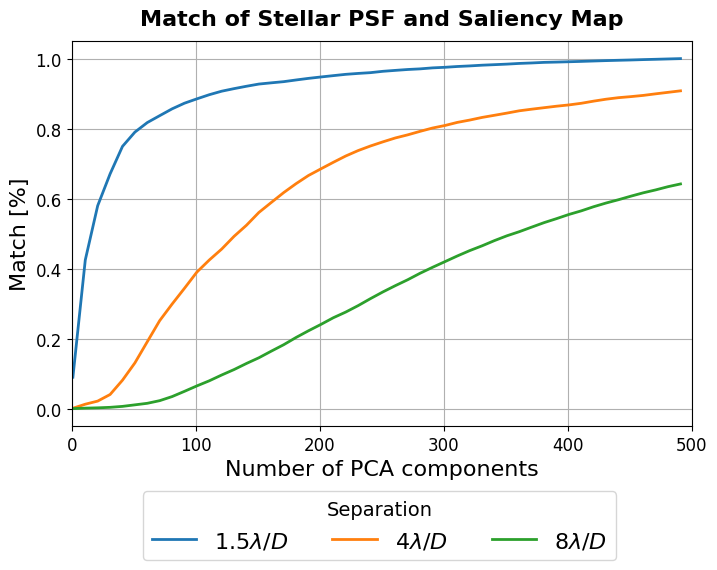

In [57]:
# 1.) Create Plot Layout ------------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 5))
gs0 = fig.add_gridspec(1, 1)

axis_match = fig.add_subplot(gs0[0, 0])

# 2.) Make the plot -----------------------------------------------
axis_match.plot(
    pca_number, pca_matches[:, 0], 
    lw=2, label="$1.5 \lambda /D$")
axis_match.plot(
    pca_number, pca_matches[:, 1], 
    lw=2, label="$4 \lambda /D$")
axis_match.plot(
    pca_number, pca_matches[:, 2], 
    lw=2, label="$8 \lambda /D$")
axis_match.grid()

# 3.) Set limits ---------------------------------------------------
axis_match.set_xlim(0, 500)
axis_match.tick_params(axis='both', which='major', labelsize=12)

# 4.) Set Labels ---------------------------------------------------
axis_match.set_xlabel(r"Number of PCA components", size=16)
axis_match.set_ylabel(r"Match [%]", size=16)

axis_match.set_title(
    r"Match of Stellar PSF and Saliency Map",
    fontsize=16, fontweight="bold", y=1.02)

# 5.) Legend -----------------------------------------------------------
handles, labels = axis_match.get_legend_handles_labels()
leg1 = fig.legend(handles, labels,
                  bbox_to_anchor=(0.20, -0.18),
                  fontsize=16,
                  title="Separation",
                  loc='lower left', ncol=3)
plt.setp(leg1.get_title(),fontsize=14)

# 5.) Save the Plot ----------------------------------------------------
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/03_match_saliency_map.pdf",
            bbox_extra_artists=(leg1,),
            bbox_inches='tight')